In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.linear_model import LinearRegression
import sqlalchemy
from sqlalchemy import create_engine
from sqlalchemy.ext.declarative import declarative_base
import statsmodels.api as sm
import matplotlib.mlab as mlab
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import StandardScaler

In [2]:
#connecting to database server
engine = sqlalchemy.create_engine('sqlite:///mydb.db') 

In [11]:
#loading the Manhattan Drive cycle data 
df = pd.read_csv("Manhattan Bus Cycle 10Hz.csv")
df = df.rename(columns={"Time (seconds)": "time", "Speed (mph)": "speed"})

#converting miles per hour to m/s
df["speed"] = df["speed"]*0.44704

In [12]:
df.head()


,time,speed
0,0.0,0.0
1,0.1,0.0
2,0.2,0.0
3,0.3,0.0
4,0.4,0.0


Estimating acceleration at different time steps in the Manhattan drive cycle

In [17]:

acc = [0]

for index in range(1,len(df.index)-1):
    a = (df.loc[index+1, "speed"]-df.loc[index-1, "speed"])/(df.loc[index+1, "time"]-df.loc[index-1, "time"])
    acc.append(a)
acc.append(0)
 


In [18]:
acc

[0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.2235199999999988,
 0.2235200000000008,
 0.0,
 0.2235200000000008,
 0.2235199999999988,
 0.0,
 0.2235200000000007,
 0.2235200000000007,
 0.0,
 0.22351999999999891,
 0.22351999999999891,
 0.0,
 0.22352000000000077,
 0.22352000000000077,
 0.0,
 0.22351999999999864,
 0.22352000000000063,
 0.0,
 0.2235200000000009,
 0.6705599999999967,
 0.8940799999999954,
 1.1176000000000037,
 1.117

In [29]:
df["acc"] = acc
df["delta_x"] = df.speed*0.1 + (0.5*df.acc*(0.1**2))
trip_length  = df.delta_x.sum()/1000

In [8]:
#duration of the trip 
trip_time = df.time.iloc[-1]/60 # trip time in min
trip_time

18.151666666666664

## Simulating energy values for various road grades , vehicle mass and auxillary power 

In [37]:
#writing the energy consumption equation

#Define constants
g=9.81 #m/s^2
#m_bus=14000 #kg (empty)
m_pax=70 #kg
C_rr=0.00697 #(without rain)
#C_rr=0.00763 #(with rain)
rho=1.2 #kg/m^3
A=7.92 #m^2
C_d=0.65
#p_aux = np.arange(4000,10000,1000) #4000 # W (without HVAC)
#p_auxi=12 #kW (with HVAC)
eta_m=0.85
eta_bat = 0.95
power= np.empty((0,1))

riders = [5*x for x in np.arange(0,9,1)]
masses = [] 
p_aux = [] 

q_heat = 30000 #30kW
p_auxx = 9000 #9 kW
h_gain  =1.8 #W
R_th = 0.0174 #K/W
T_in = 18.9 #celcius 
T_out = -20
C_p = 1.005 #KJ/KG.K
rho = 1.2
V_inf = 0
V_hv = 1.13 #m^3/sec
psi = 0.20 # 20%

for rider in riders:
    masses.append(14000+70*rider)
    p_aux.append((q_heat - ((T_in-T_out)/R_th) - (rho*C_p*(T_in-T_out)*V_inf ) - (psi*V_hv* rho*C_p*(T_in-T_out)) + (h_gain*rider)+ p_auxx))


#generate a possible sampling distrbution to select data from ????
grades = np.arange(-0.1,0.1,0.005)
#masses = np.arange(14000, 15000,70)
time  = 0.1 #0.1 sec 
p_max = 90000 #90kw
e_bat = 215 #215 kwh
data = np.empty((0,3))

for grade in grades:
    for m_bus in masses: 
        for p_auxi in p_aux:
            data = np.append(data, np.array([[np.sin(grade), m_bus,p_auxi]]), axis=0)
            df["power"] = m_bus*df.speed*df.acc+m_bus*g*np.sin(grade)*df.speed+m_bus*g*C_rr*df.speed+0.5*rho*A*C_d*df.speed**3
            for index in df.index:
                if df["power"].loc[index] > 0.0:
                    df.loc[index, "denergy"] = ((df["power"].loc[index]*time)/(eta_m*eta_bat) )+ (p_auxi*time/eta_bat)
                elif df["power"].loc[index] < 0.0 and df["acc"].loc[index] < -3.0 and df["speed"].loc[index] >5.0:
                    df.loc[index, "denergy"] = -(abs(df["power"].loc[index]*time)*(eta_m*eta_bat) )+ (p_auxi*time/eta_bat)
                elif (df["power"].loc[index] < 0.0 and df["acc"].loc[index] > -3.0) or df["speed"].loc[index] <5.0:
                    df.loc[index, "denergy"] = -(p_max*time) + (p_auxi*time/eta_bat)
                elif df["power"].loc[index] == 0.0:
                    df.loc[index, "denergy"] = (p_auxi*time/eta_bat)
            power = np.append(power, df.denergy.sum()/trip_length)



In [31]:
riders 

[0, 5, 10, 15, 20, 25, 30, 35, 40]

In [38]:
ener = np.array([i*2.7778e-7 for i in power])# convert to kwh/km
ener = pd.DataFrame(ener)
ener.to_sql("simu_data", con=engine, if_exists ="replace")

In [39]:
query = "SELECT * FROM simu_data"
ener = pd.read_sql(query, engine)

In [40]:
ener = ener.drop(columns = "index")
ener

,0
0,-4.077792
1,-4.076930
2,-4.076068
3,-4.075206
4,-4.074344
...,...
3235,6.064800
3236,6.065662
3237,6.066524
3238,6.067386


Plotting figuers to check for linearity 

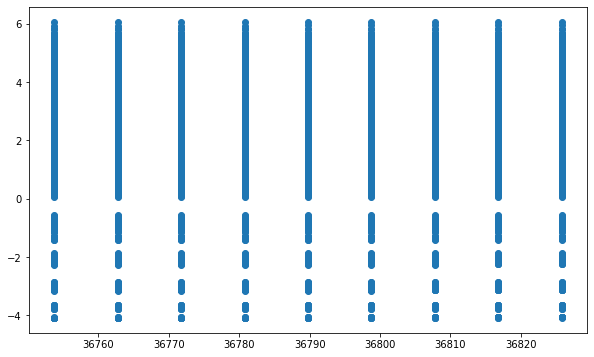

In [41]:

plt.figure(figsize =(10, 6)) 
plt.scatter((data[:,2]), ener)


#np.sin(np.arange(-1,1,0.01))
plt.show()

## Trying Linear regression 

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, ener, test_size=0.2, random_state=0)

In [127]:
regressor = LinearRegression()
regressor.fit(X_train, y_train)
print (regressor.coef_, regressor.intercept_)

[[8.60571043e+01 4.27225398e-03 1.53731978e-04]] [-40.94550984]


In [128]:
y_pred = regressor.predict(X_train)

In [129]:
from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(y_train, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_train, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_train, y_pred)))

Mean Absolute Error: 17.888670657971005
Mean Squared Error: 403.3770103115278
Root Mean Squared Error: 20.084247815428085


In [46]:
residual = y_pred - y_test

(array([660.,   0., 660.,   0.,   0.,   0., 660.,   0.,   0., 660.]),
 array([-12537.91767364, -10569.78185375,  -8601.64603387,  -6633.51021399,
         -4665.3743941 ,  -2697.23857422,   -729.10275433,   1239.03306555,
          3207.16888543,   5175.30470532,   7143.4405252 ]),
 <a list of 10 Patch objects>)

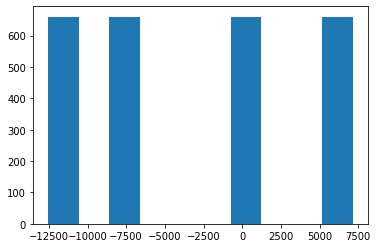

In [102]:
plt.hist(data[:,0])

The errors are not normally distribited hence linear regression doesn't seems to fit on our data.

## Trying polynomial regression with elastic net 


In [20]:
from sklearn import datasets
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import ElasticNet

In [21]:
def elastic_net(x, y, degree, alph = 0.001, l1_ratio = 0.8 ):
    # Add a bias term to the dataset
    x = sm.add_constant(x)
    
    # Create polynomial features
    poly_feats = PolynomialFeatures(degree)
    x = poly_feats.fit_transform(x)
    
#     # Split into training and validation set
    x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=0)
    
#     # Fit the polynomial regression model
#     my_reg = sm.OLS(y_train, x_train).fit()
    
     # Fit the elastic net regression model
    my_reg = ElasticNet( alpha = alph, l1_ratio = l1_ratio, 
                        max_iter = 1e5).fit(x_train, y_train)
    
    # Make predictions
    val_preds = my_reg.predict(x_val)
    train_preds = my_reg.predict(x_train)
    val_mse = mean_squared_error(y_val, val_preds)
    train_mse = mean_squared_error(y_train, train_preds)
    print("Degree:", degree, "\n", 
          "Train MSE:", train_mse, "\n", "Valid MSE:", val_mse, "\n", "coef :", my_reg.coef_)
    
    return train_mse, val_mse

In [22]:
deg_list = [5, 6,7,8]
t_mse, v_mse = [], []
for deg in deg_list:
    t, v = elastic_net(data, ener, deg)
    t_mse.append(t)
    v_mse.append(v)

C:\Users\upadh\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.7878422846227653, tolerance: 0.40378814432487886
  positive)


Degree: 5 
 Train MSE: 0.010761596697292188 
 Valid MSE: 0.010548313933412136 
 coef : [ 0.00000000e+00  0.00000000e+00 -0.00000000e+00  1.27596360e-04
  0.00000000e+00  0.00000000e+00 -0.00000000e+00  2.63149945e-06
  0.00000000e+00 -0.00000000e+00  2.91731975e-04  5.61202298e-06
 -5.82434167e-10  2.28831581e-09  3.70259551e-08  0.00000000e+00
 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00
 -1.09031114e-05  4.50137873e-06 -2.71825560e-09  2.26423890e-09
 -4.38458005e-10  0.00000000e+00  2.90907486e-04  1.01974597e-05
  2.24366609e-09  2.64762213e-10  1.55374640e-10 -1.39428103e-13
 -5.69429380e-14  5.68985916e-14 -2.48152712e-13  0.00000000e+00
 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00
 -1.59618979e-05  4.59574245e-06 -2.19713879e-09  2.27574822e-09
  1.39325375e-08  0.00000000e+00  2.15023819e-05  9.71557688e-06
 -6.95215671e-10  2.64845704e-10  1.55417240e-10 -5.17602543e-14
 -5.70325825e-14  5.68064479e-14 -2.69805401e-13 -0.00000000e+00
  7

C:\Users\upadh\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.7868601958902945, tolerance: 0.40378814432487886
  positive)


Degree: 6 
 Train MSE: 0.01075801388714695 
 Valid MSE: 0.010543192203370268 
 coef : [ 0.00000000e+00  0.00000000e+00 -0.00000000e+00  1.15221584e-04
  0.00000000e+00  0.00000000e+00 -0.00000000e+00  2.63141291e-06
  0.00000000e+00 -0.00000000e+00  2.95384863e-04  3.38887094e-06
  4.37141925e-10  1.62198398e-09  5.16505200e-08  0.00000000e+00
 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00
 -5.62591467e-06  2.28241228e-06 -1.88318373e-09  1.58961378e-09
 -2.83796198e-10  0.00000000e+00  2.62866820e-04  8.63158088e-06
  2.43157671e-09  1.63250475e-10  9.53250107e-11 -1.56499801e-13
 -1.21633844e-14  3.85191866e-14 -2.48479087e-13  0.00000000e+00
 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00
 -9.93792073e-06  2.38360205e-06 -1.56507549e-09  1.60104627e-09
  1.40826186e-08  0.00000000e+00  2.06123614e-05  8.18226068e-06
 -2.16926095e-10  1.64570499e-10  9.58928888e-11 -7.76692815e-14
 -1.22371484e-14  3.84421515e-14 -2.67840047e-13 -0.00000000e+00
  4.

Identifying best degree for polynomial regression 

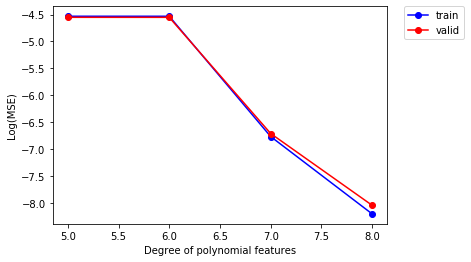

In [23]:
#plot with just polynomial regression 
plot1 = plt.plot(deg_list, np.log(t_mse), '-ob', label = 'train')
plot2 = plt.plot(deg_list, np.log(v_mse), '-or', label = 'valid')
plt.ylabel("Log(MSE)")
plt.xlabel("Degree of polynomial features")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [101]:
#testing on various values for lambda one and lambda two based on alpha and l1_ratio 
alph_list = [0.001, 0.01, 0.1, 0.2, 0.9]
t_mse, v_mse = [], []
for alph in alph_list:
    t, v = elastic_net(data, ener, 6, alph)
    t_mse.append(t)
    v_mse.append(v)

C:\Users\upadh\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 867.560895324321, tolerance: 133.04133027822775
  positive)


Degree: 6 
 Train MSE: 3.1214920088653577 
 Valid MSE: 3.071909761209634


C:\Users\upadh\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 918.1609383285254, tolerance: 133.04133027822775
  positive)


Degree: 6 
 Train MSE: 3.544629772596556 
 Valid MSE: 3.472628994299679


C:\Users\upadh\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 918.8050068551748, tolerance: 133.04133027822775
  positive)


Degree: 6 
 Train MSE: 3.5449100253787384 
 Valid MSE: 3.4756651084318197


C:\Users\upadh\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 919.2777388074085, tolerance: 133.04133027822775
  positive)


Degree: 6 
 Train MSE: 3.5451512490327386 
 Valid MSE: 3.4749230555515567
Degree: 6 
 Train MSE: 3.544974187742565 
 Valid MSE: 3.472687787007094


C:\Users\upadh\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 920.806425853107, tolerance: 133.04133027822775
  positive)


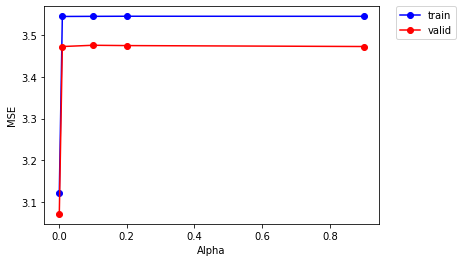

In [102]:
#plot with polynomial of degree two and elastic net model 
plot1 = plt.plot(alph_list, t_mse, '-ob', label = 'train')
plot2 = plt.plot(alph_list, v_mse, '-or', label = 'valid')
plt.ylabel("MSE")
plt.xlabel("Alpha")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

Looks like elastic net is not increasing the accuracy of the model even after playing with multiple values of alpha and L1. Bus this is because the simulated data is not collinear while the real data might be. If we simualate mass and auxillary power as fuction of ridership, this model might make for sense. Hence, let's use the degree two polynomial for the curve without ridge regession parameters in this case.

## Fitting a neural netwrok regressor for prediction 

In [56]:
#creating the input data 
X = data
Y = ener.iloc[:,0].values

In [57]:
#Normalizing the data
sc = StandardScaler()
X = sc.fit_transform(X)

In [49]:
import pandas
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [58]:
# define base model
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(3, input_dim=3, kernel_initializer='normal', activation='relu'))
    model.add(Dense(6, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal', activation='softmax'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

# evaluate model
estimator = KerasRegressor(build_fn=baseline_model, epochs=100, batch_size=5, verbose=0)
kfold = KFold(n_splits=10)
results = cross_val_score(estimator, X, Y, cv=kfold)
print("Baseline: %.2f (%.2f) MSE" % (results.mean(), results.std()))

Baseline: -2436.93 (3277.99) MSE


We see that neural network regression gives a large mean square error . This is because neural network is not able to account for interaction between independent variables.This was best encountered in polynomial regression and hence fits the best. Further, since my current dataset doesn't have collineararity, the elstic net is not able to fit a better model. Making mass and auxillary power depending on riderhsip might solve this problem. 